In [1]:
import warnings
from itertools import product

import dill
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import shap
import xgboost
from joblib import Parallel, delayed, load
from numba import jit
from sklearn.base import BaseEstimator
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split

import lightgbm

RAND = 0
warnings.filterwarnings("ignore")

In [2]:
df_train = pl.read_parquet("dataframe.parquet")
X = df_train.to_pandas()
X.set_index("case_id", inplace=True)
del df_train
weeks = X.pop("WEEK_NUM")
y = X.pop("target")
cat_features = X.select_dtypes(exclude=np.number).columns.tolist()
num_features = X.select_dtypes(include=np.number).columns.tolist()

In [3]:
imputer_cat = SimpleImputer(missing_values=None, strategy="constant", fill_value="None")
X[cat_features] = imputer_cat.fit_transform(X[cat_features], y)
X[cat_features] = X[cat_features].astype(pd.CategoricalDtype())

In [4]:
X_train, X_test, y_train, y_test, weeks_train, weeks_test = train_test_split(
    X, y, weeks, test_size=0.2, stratify=y, shuffle=True, random_state=RAND
)

# Feature importance

Найдем наиболее важные признаки для наилучшей Stacking модели с 3 baseline моделями и 4 tuned CatBoost, 4 LightGBM и 4 XGBoost моделями.

In [119]:
with open("best_model.bin", "rb") as fout:
    model = dill.load(fout)

In [128]:
@jit(fastmath=True)
def custom_masker(mask: np.ndarray, X: np.ndarray) -> np.ndarray:
    """In this simple masker we just zero out the features we are masking and str features.

    Parameters
    ----------
    mask: array-like of shape (n_samples,)
        bool mask
    X: {array-like, sparse matrix, DataFrame} of shape (n_samples, n_features)
        Training / test vectors, where `n_samples` is the number of samples and
        `n_features` is the number of features.

    Returns
    -------
    out : np.ndarray
        masked X row of train/test data
    """
    masked = X * mask
    for i in range(len(masked)):
        if isinstance(masked[i], str):
            masked[i] = 0
    return masked.reshape(1, len(X))

In [ ]:
func = lambda x: model.predict_proba(x)
explainer = shap.PermutationExplainer(func, custom_masker, n_jobs=2, seed=0)
shap_values = explainer(shap.sample(X_test, 1000))

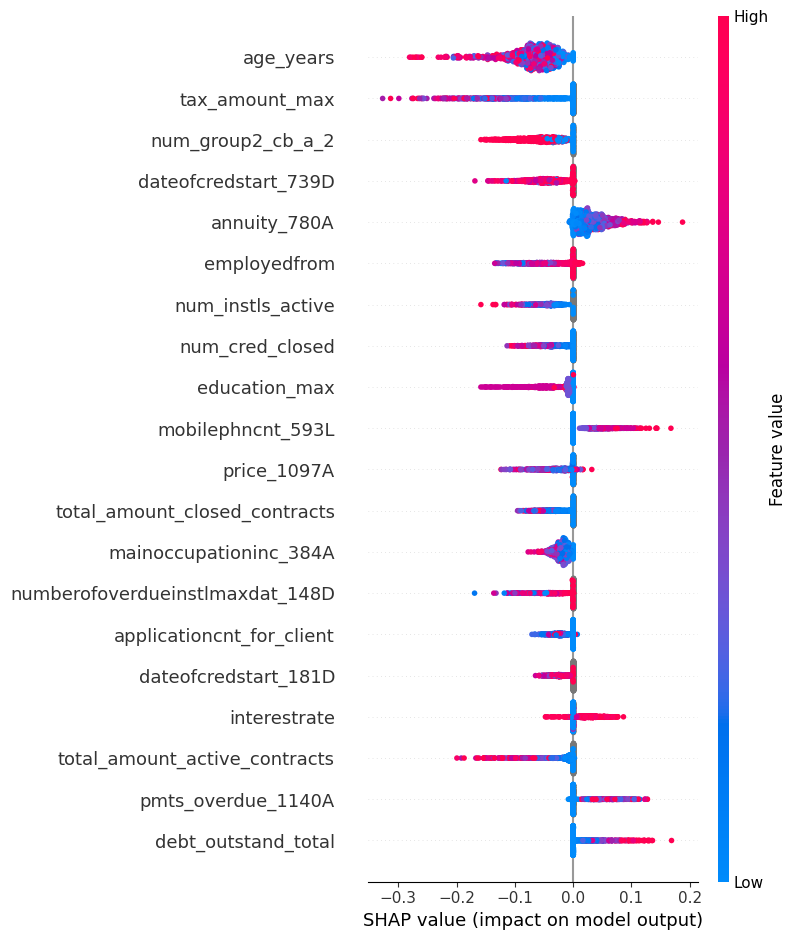

In [133]:
shap.summary_plot(shap_values[..., 1])

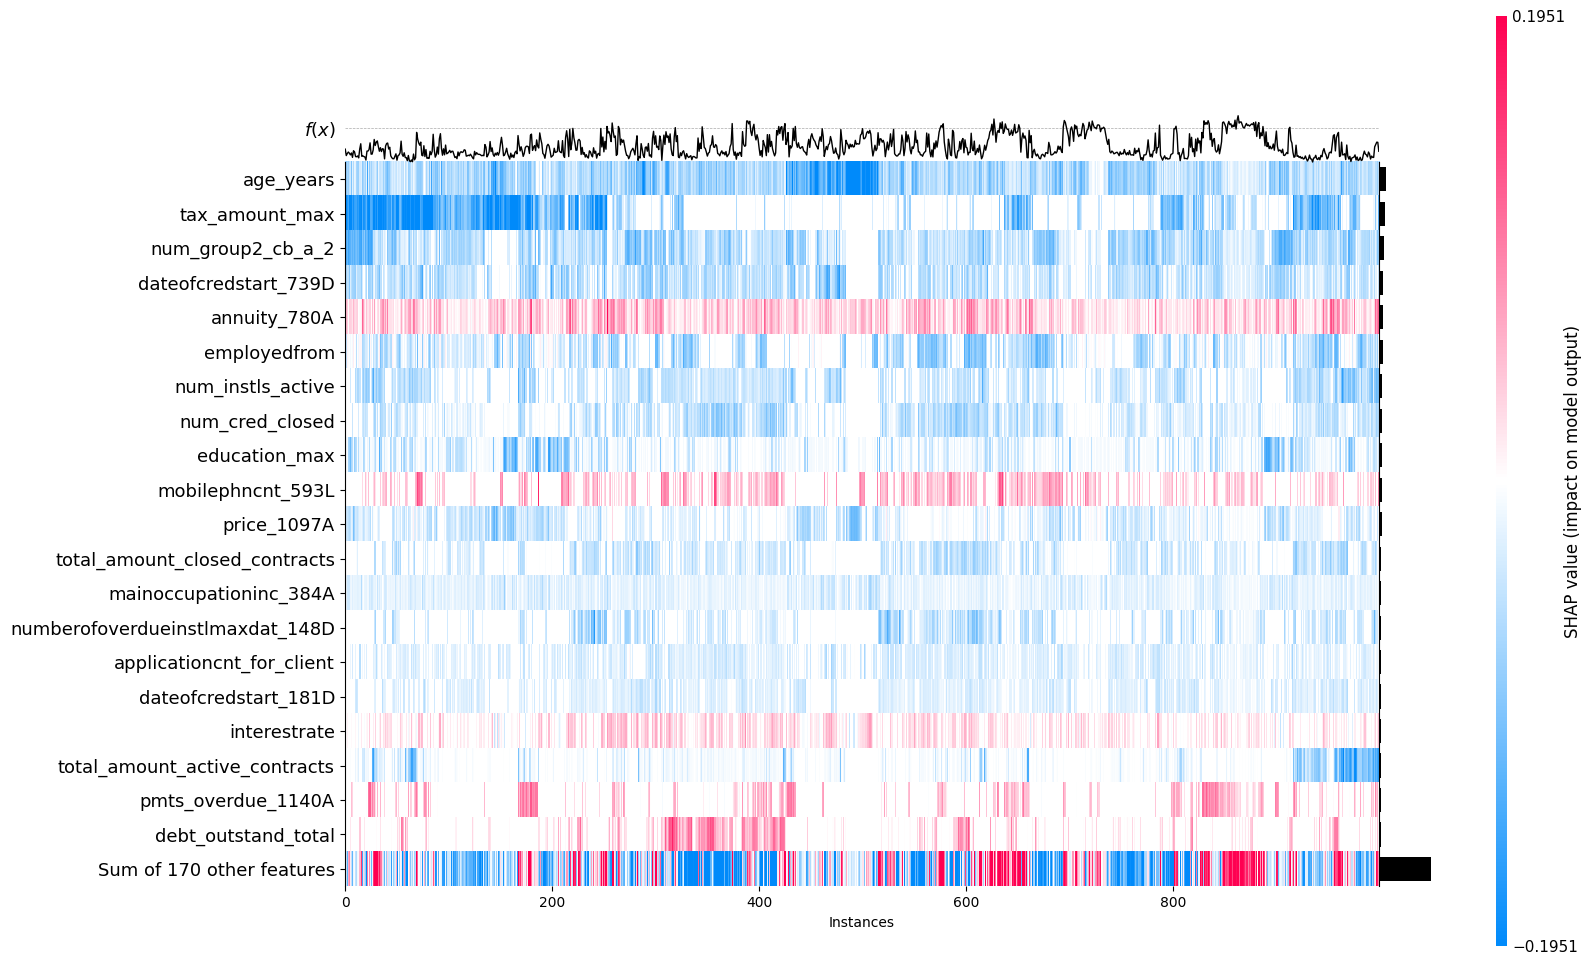

In [134]:
shap.plots.heatmap(shap_values[..., 1], max_display=21, plot_width=15)

Первые 20 признаков конечно значимы, но и остальные 170 признаков тоже оказывают большое влияние на решение модели.

In [8]:
def show_scatter_plot(shap_values: np.ndarray, features: list[str]) -> None:
    """Plot 4 scatter plots for shap_values by 4 features

    Parameters
    ----------
    shap_values: np.ndarray
         matrix of SHAP values (# samples x # features).
         Each row sums to the difference between the model output
    features: list[str]
        4 feature names
    """
    assert len(features) == 4, "4 feature names must be passed"
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))
    for i, ax_id in enumerate(list(product([0, 1], repeat=2))):
        shap.plots.scatter(
            shap_values[..., 1][:, features[i]], ax=axes[ax_id], show=False
        )

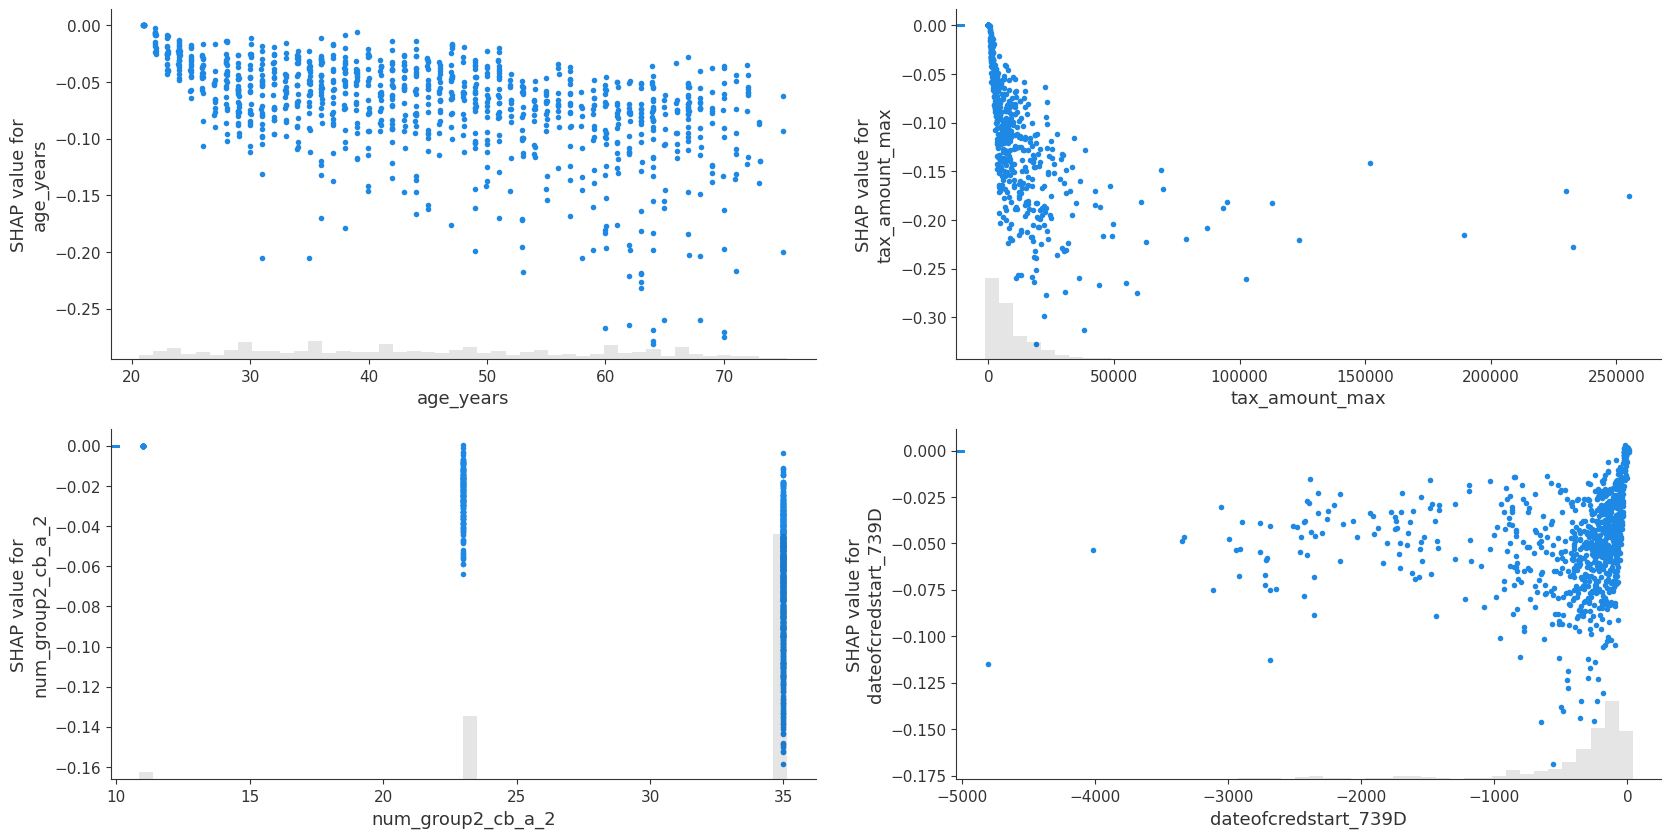

In [9]:
show_scatter_plot(
    shap_values,
    ["age_years", "tax_amount_max", "num_group2_cb_a_2", "dateofcredstart_739D"],
)

- Чем больше возраст, тем ниже в среднем вероятность дефолта.
- tax_amount_max: Максимальный размер налога. Чем заемщик платит больше налогов, тем ниже вероятность дефолта.
- dateofcredstart_739D. Дата начала закрытого кредитного договора (в днях). Чем больше прошло дней с даты начала прошлого кредита, тем ниже вероятность дефолта.

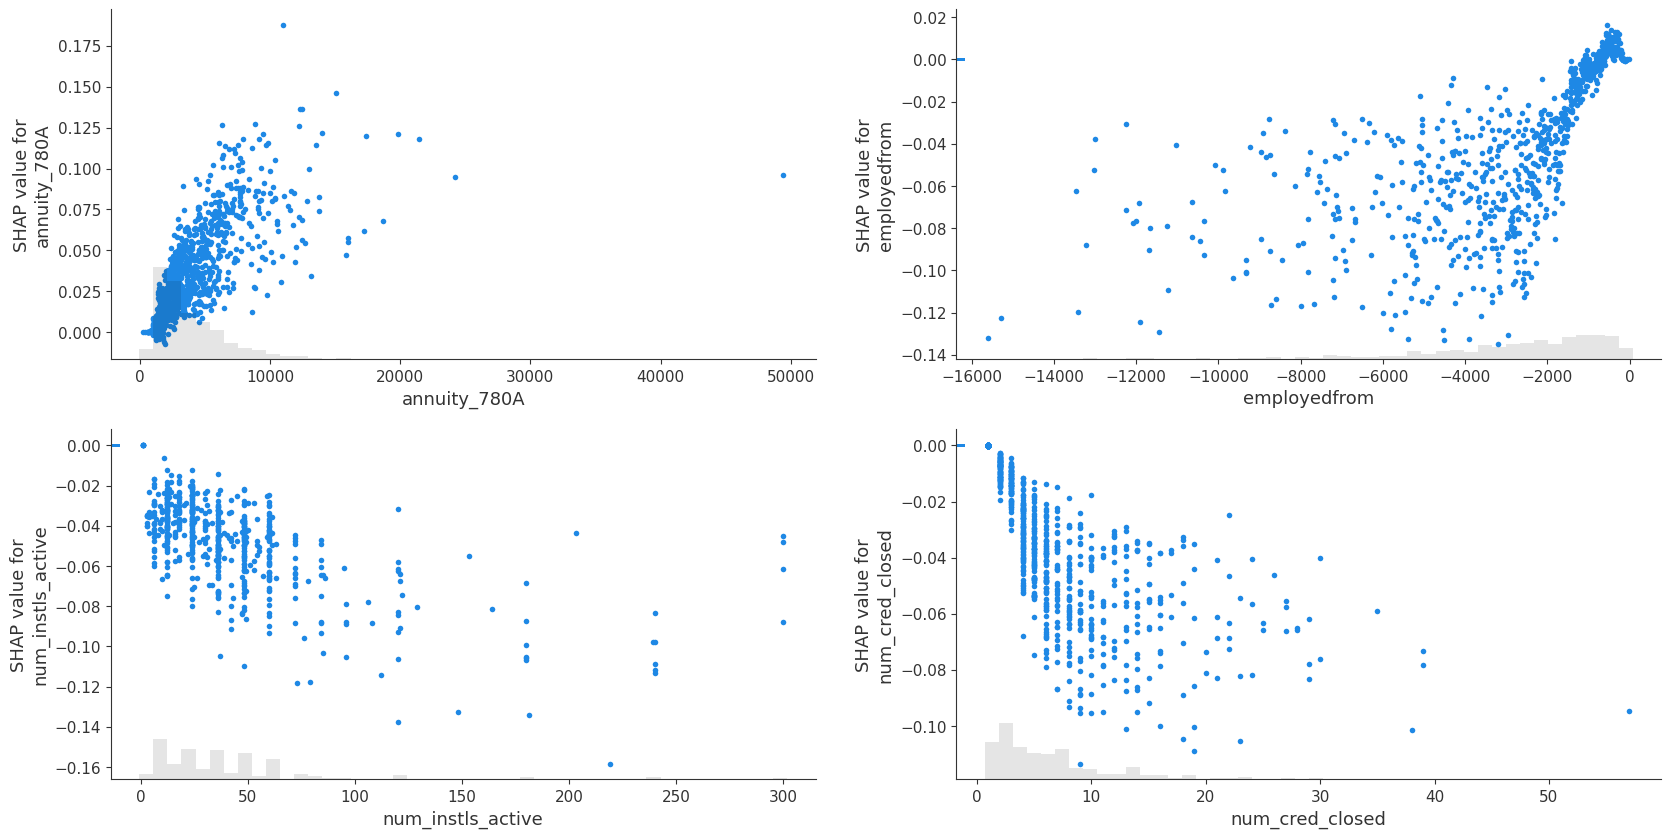

In [10]:
show_scatter_plot(
    shap_values,
    ["annuity_780A", "employedfrom", "num_instls_active", "num_cred_closed"],
)

- annuity_780A: Размер ежемесячного платежа. Чем выше размер, тем выше вероятность дефолта.
- pmts_dpd_303P: Дни просрочки платежа по расторгнутому договору по данным кредитного бюро. Соответственно чем меньше количество дней, тем ниже вероятность дефолта.
- debt_outstand_total: Общая сумма непогашенного долга. Чем выше значение, тем выше вероятность дефолта по кредиту.
- isbidproduct: Флаг, указывающий, является ли продукт перекрестной продажей. По этому признаку SHAP values хорошо разделяются. Для значения False признак всегда склоняет выход модели в отрицательную область.

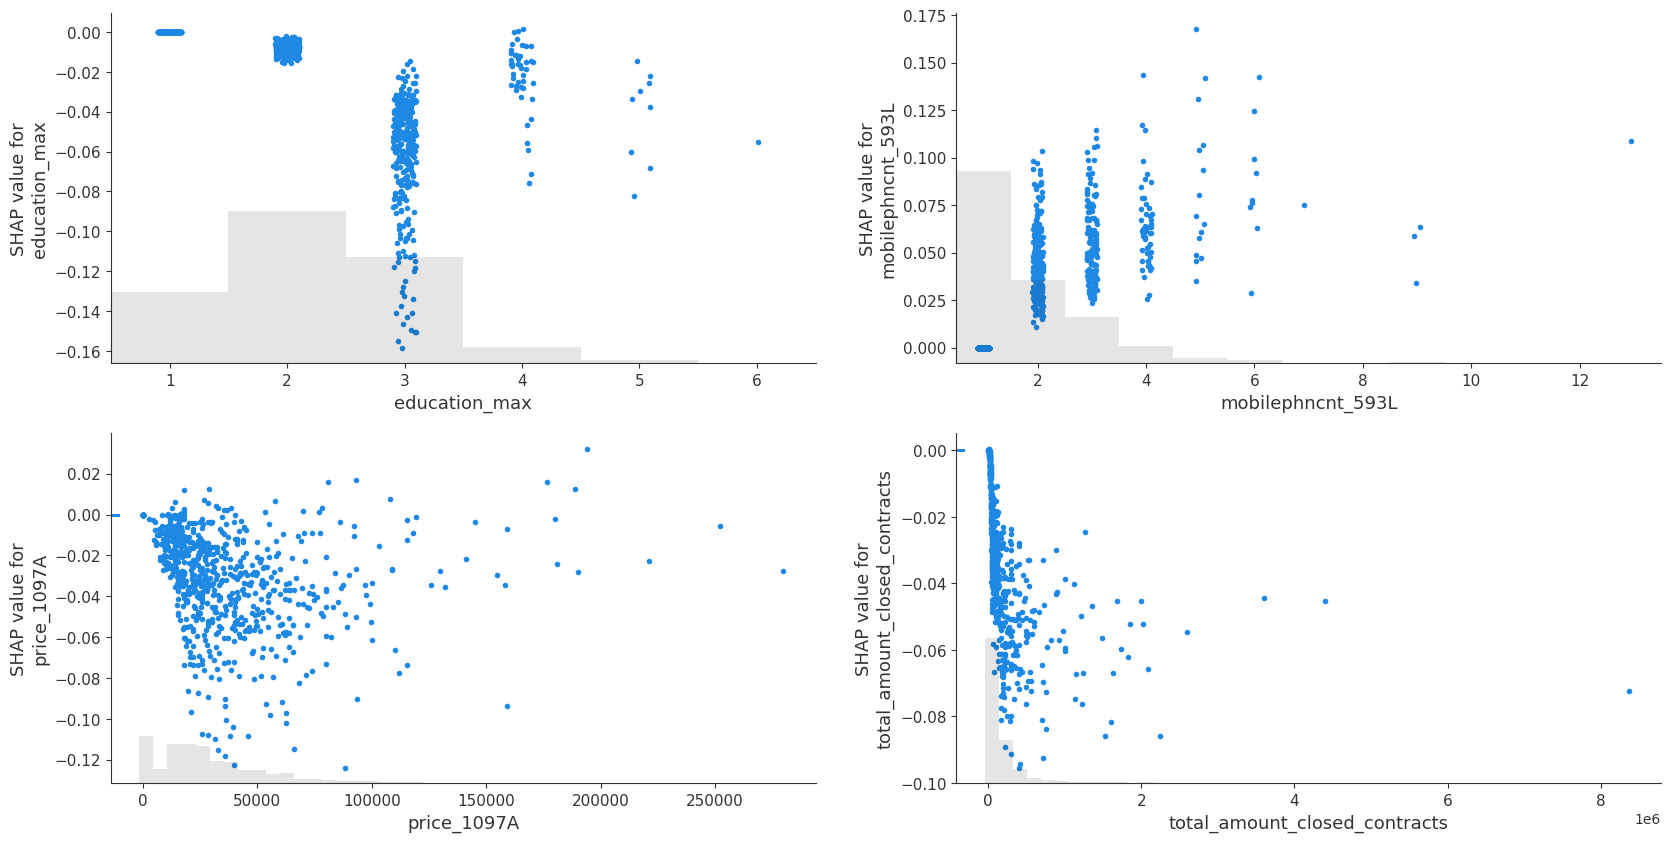

In [11]:
show_scatter_plot(
    shap_values,
    [
        "education_max",
        "mobilephncnt_593L",
        "price_1097A",
        "total_amount_closed_contracts",
    ],
)

- education_max: Наблюдается различие для образования клиента, так с образованием 3 ниже всего вероятность дефолта.
- mobilephncnt_593L: Количество людей с одинаковым номером мобильного телефона. Чем выше, тем хуже.
- price_1097A: Общая сумма кредита. До суммы 50000 вероятность дефолта выше при меньших суммах. Свыше 50000 чем выше сумма кредита, тем выше вероятность дефолта по кредиту.
- total_amount_closed_contracts: Сумма закрытых контрактов. Чем больше эта сумма и данные вообще есть, тем вероятность дефолта ниже.

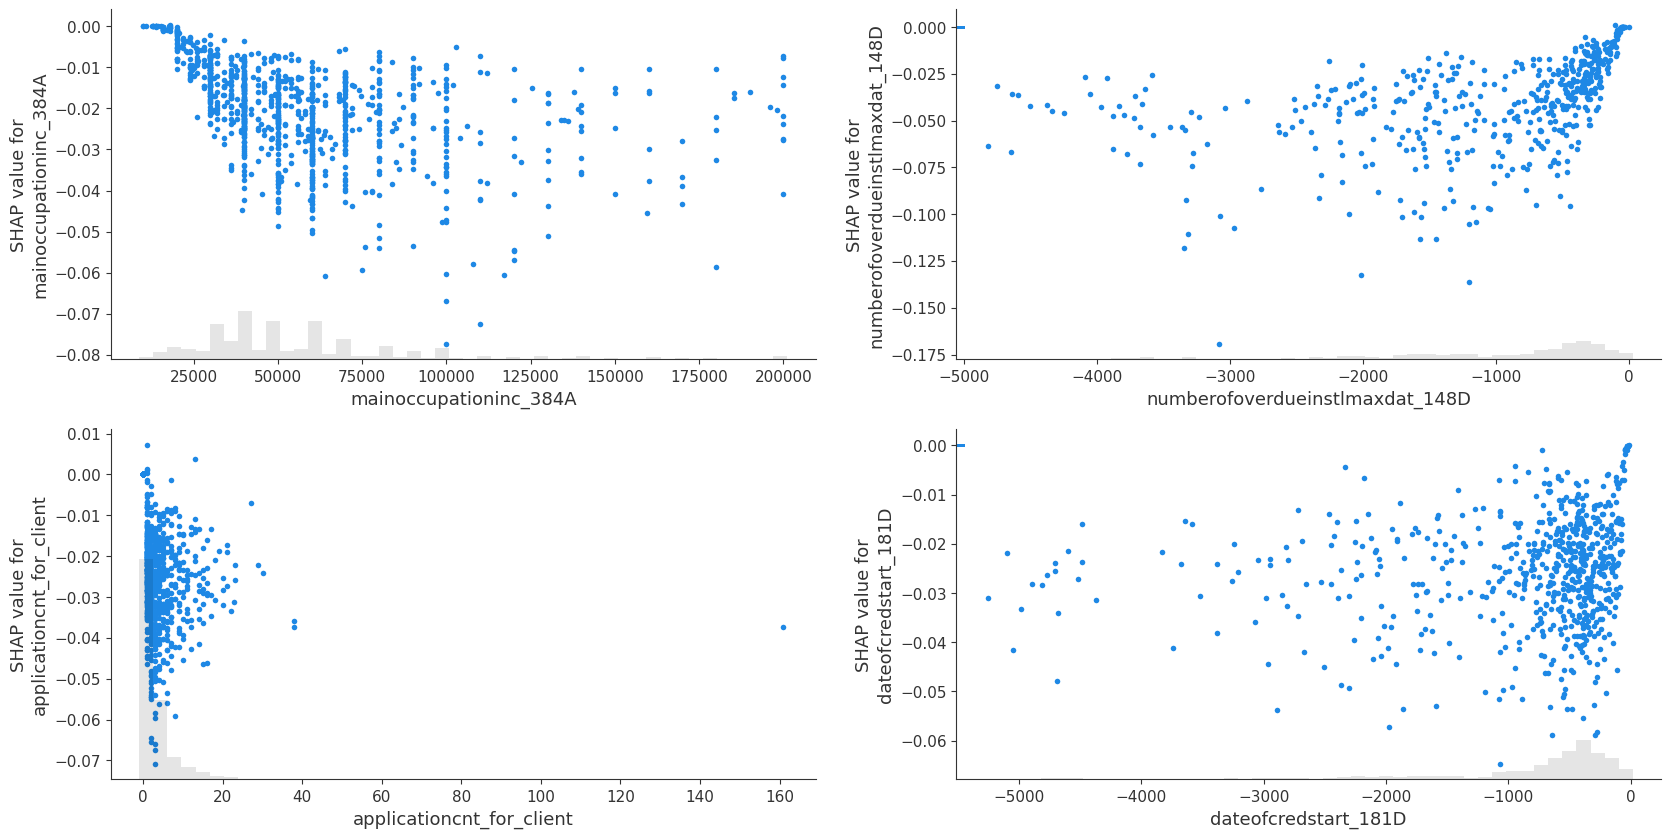

In [12]:
show_scatter_plot(
    shap_values,
    [
        "mainoccupationinc_384A",
        "numberofoverdueinstlmaxdat_148D",
        "applicationcnt_for_client",
        "dateofcredstart_181D",
    ],
)

- mainoccupationinc_384A: Размер основного дохода клиента. Чем выше доход, тем ниже вероятность дефолта.
- numberofoverdueinstlmaxdat_148D: Дата максимального количества просроченных платежей по закрытому договору (в днях). Чем значение ближе к 0, тем хуже для заемщика. Значит недавно были просрочки.
- applicationcnf_for_client: Количество приложений, связанных с одним и тем же клиентом. Чем больше, тем ниже вероятность дефолта.
- dateofcredstart_181D: Дата закрытия кредитного договора (в днях). Оптимальное значение примерно от 300 до 1000 дней, но четкой зависимости не прослеживается. Чем меньше дней прошло с предыдущего контракта, тем выше вероятность дефолта.

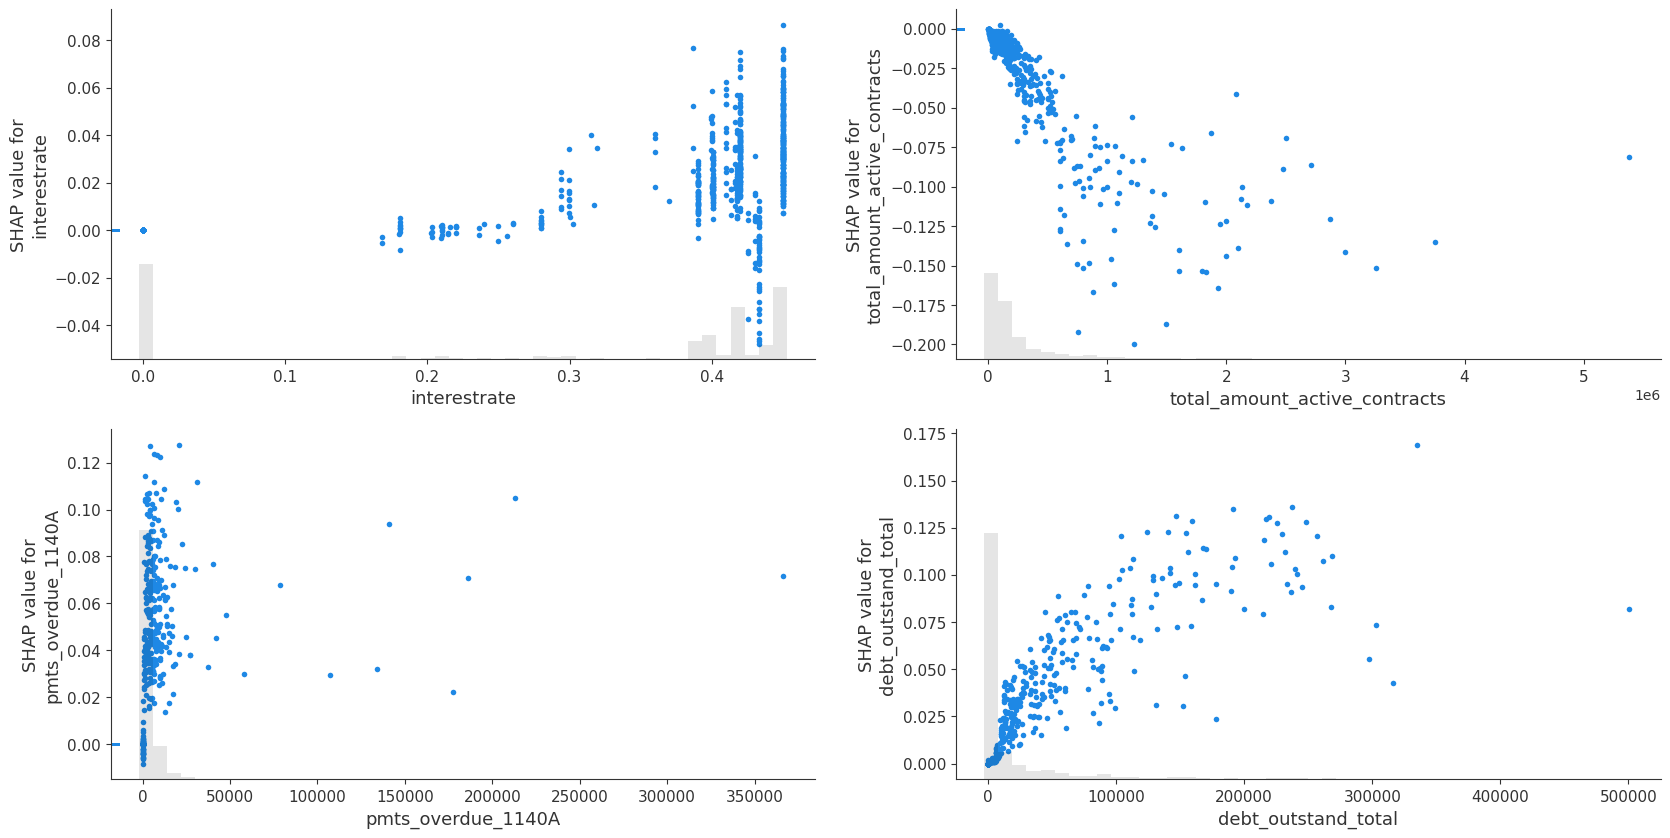

In [13]:
show_scatter_plot(
    shap_values,
    [
        "interestrate",
        "total_amount_active_contracts",
        "pmts_overdue_1140A",
        "debt_outstand_total",
    ],
)

- interestrate: Процентная ставка. Чем выше ставка, тем выше вероятность дефолта.
- total_amount_active_contracts: Сумма активных контрактов. Чем больше эта сумма и данные вообще есть, тем вероятность дефолта ниже.
- pmts_overdue_1140A: Просроченная оплата по активному договору. Если нет данных, то выроятность дефолта ниже. Если и размер просроченной оплаты выше, то и вероятность дефолта выше.
- debt_outstand_total: Общая сумма непогашенного долга. Чем выше значение, тем выше вероятность дефолта по кредиту.

## Вывод

Изучены наиболее значимые признаки. Среди них ожидаемо оказались: трудовой стаж, размер налогов, возраст, размер ежемесячного платежа, количество просрочек по предвыдущим кредитам, количество активных кредитов.

# Finance сравнение с baseline

Сравним насколько хорошо лучшая модель StackingClassifierCustom позволит получить больше прибыли по сравнению с baseline CatBoost.

In [5]:
with open("baseline_catboost.bin", "rb") as fout:
    baseline_catboost = dill.load(fout)
with open("best_model.bin", "rb") as fout:
    best_model = dill.load(fout)
with open("best_model_calib.bin", "rb") as fout:
    best_model_calib = dill.load(fout)

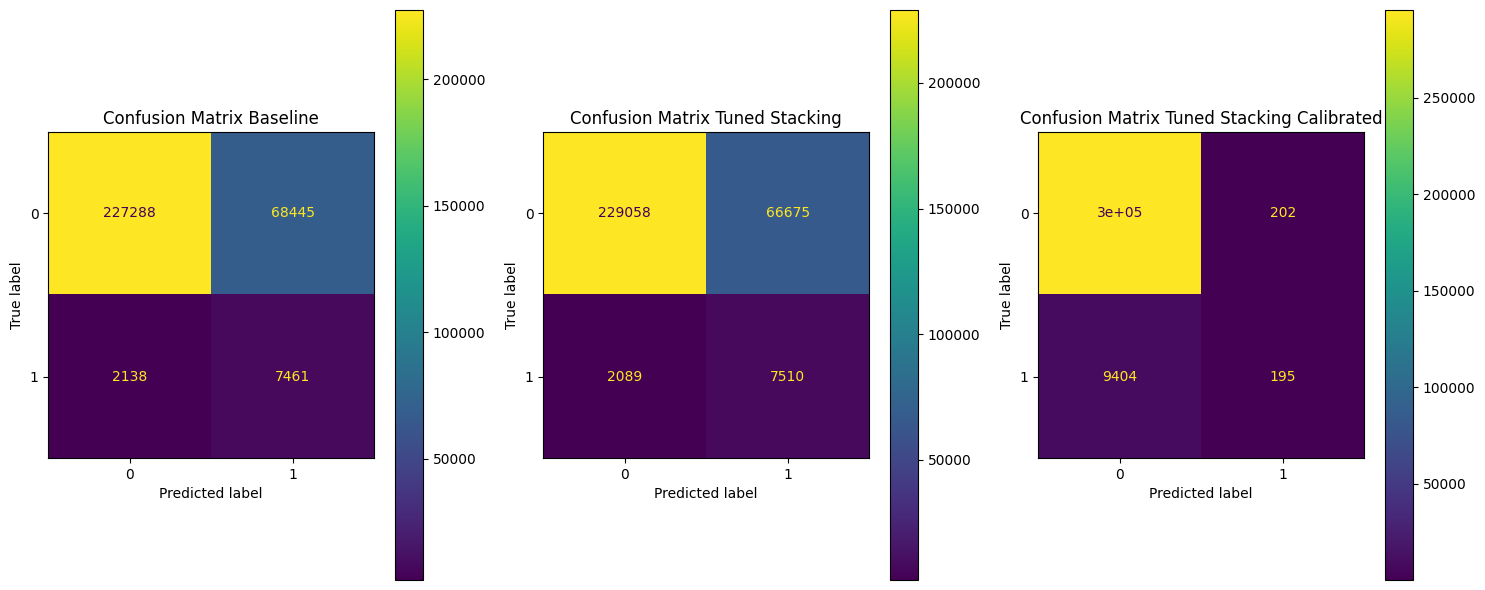

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
ConfusionMatrixDisplay.from_estimator(baseline_catboost, X_test, y_test, ax=ax[0])
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, ax=ax[1])
ConfusionMatrixDisplay.from_estimator(best_model_calib, X_test, y_test, ax=ax[2])
ax[0].title.set_text("Confusion Matrix Baseline")
ax[1].title.set_text("Confusion Matrix Tuned Stacking")
ax[2].title.set_text("Confusion Matrix Tuned Stacking Calibrated")
plt.tight_layout()
plt.show()

In [19]:
def finance(
    model: BaseEstimator, credamount: pd.Series, y_true: pd.Series, X: pd.DataFrame
) -> tuple:
    """Estimate saved and lost money using current model.

    Returns amount of saved_money as tp_sum + tn_sum,
    amount of lost money as fp_sum + fn_sum
    and percent as lost_money / maximal possible saved money amount

    Parameters
    ----------
    model: BaseEstimator

    credamount: pd.Series
        With values of credit price.

    y_true: array-like of shape (n_samples,)
        True labels.

    X: {array-like, sparse matrix, DataFrame} of shape (n_samples, n_features)
        Predict on this vectors, where `n_samples` is the number of samples and
        `n_features` is the number of features.
    Returns
    -------
    out : tuple
        saved_money, lost_money, percent
    """
    y_pred = model.predict(X)
    tp_sum = 0
    fp_sum = 0
    tn_sum = 0
    fn_sum = 0
    for i in range(credamount.shape[0]):
        amount = credamount.iloc[i]
        true_label = y_true.iloc[i]
        pred_label = y_pred[i]
        if true_label == pred_label == 1:
            tp_sum += amount
        elif true_label == pred_label == 0:
            tn_sum += amount
        elif pred_label == 1:
            fp_sum += amount
        elif pred_label == 0:
            fn_sum += amount
    saved_money = tp_sum + tn_sum
    lost_money = fp_sum + fn_sum
    max_possible_win = credamount.sum()
    percent = lost_money * 100 / max_possible_win
    return saved_money, lost_money, round(percent, 2)

In [21]:
saved_money_b, lost_money_b, percent_b = finance(
    baseline_catboost, X_test["credamount_770A"], y_test, X_test
)
saved_money_b, lost_money_b, percent_b

(11506872384.617004, 3749151178.039026, 24.57)

In [22]:
saved_money, lost_money, percent = finance(
    best_model, X_test["credamount_770A"], y_test, X_test
)
saved_money, lost_money, percent

(11629380858.017824, 3626642704.638225, 23.77)

In [44]:
saved_money_с, lost_money_с, percent_с = finance(
    best_model_calib, X_test["credamount_770A"], y_test, X_test
)
saved_money_с, lost_money_с, percent_с

(14716064478.072054, 539959084.5842001, 3.54)

In [45]:
percent_delta = round(percent_b - percent, 1)
money_delta = round(saved_money - saved_money_b, 1)
print(f"Разница в сохраненной сумме в % у моделей = {percent_delta} %")
print(f"Разница в сохраненной сумме у моделей = {money_delta}")

Разница в сохраненной сумме в % у моделей = 0.8 %
Разница в сохраненной сумме у моделей = 122508473.4


In [47]:
percent_delta = round(percent_b - percent_с, 1)
money_delta = round(saved_money_с - saved_money_b, 1)
print(f"Разница в сохраненной сумме в % у моделей = {percent_delta} %")
print(f"Разница в сохраненной сумме у моделей = {money_delta}")

Разница в сохраненной сумме в % у моделей = 21.0 %
Разница в сохраненной сумме у моделей = 3209192093.5


## Вывод

Видим что количество ложно-положительных предсказаний FP (отказали "хорошему" клиенту) намного больше количества ложно-отрицательных FN (дали кредит тому кто не вернет). Stacking модель без калибровки немного уменьшает количество ошибок 1 и 2 рода и позволяет сохранить 122,5 млн , что на 0.8 % больше чем для Baseline модели. Но если ослабить критерии и начать выдавать кредиты почти всем, т.к. оказывается что порядочных заемщиков больше, то выйгрыш по деньгам будет уже 21 % и 3.2 млрд $, а разница от максимально возможной прибыли будет 3.54 % против 23.77 у модели без калибровки. Поэтому выгоднее уменьшить количество именно ложно-положительных результатов, даже ценой увеличения количества FN.